## 3.1 线性回归

### 3.1.2 矢量化加速

In [2]:
%matplotlib inline

import math
import time
import numpy as np  
import torch
from d2l import torch as d2l

In [5]:
n = 100
a = torch.ones([n])
b = torch.ones([n])

In [4]:
class Timer: #@save

  """记录多次运行时间"""
  def __init__(self):
    self.times = []
    self.start()

  def start(self):
    """启动计时器"""
    self.tik = time.time()
  
  def stop(self):
    """停止计时器并将时间记录在列表中"""
    self.times.append(time.time() - self.tik)
    return self.times[-1]
  
  def avg(self):
    """返回平均时间"""
    return sum(self.times) / len(self.times)

  def sum(self):
    """返回时间总和"""
    return sum(self.times)

  def cumsum(self):
    """返回累计时间"""
    return np.array(self.times).cumsum().tolist()


In [6]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
  a[i] = a[i] + b[i]

f'{timer.stop():.5f}'.format(timer)

'0.01795'

In [8]:
timer.start()
d = a + b
f'{timer.stop():.5f}'.format(timer)

'0.00100'

### 3.1.3 正态分布与平方损失

In [9]:
def normal(x, mu, sigma):
  p = 1 / math.sqrt(2 * math.pi * sigma **2 )
  return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

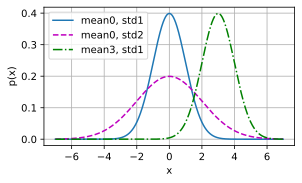

In [10]:
x = np.arange(-7, 7, 0.01)

params = [(0, 1), (0, 2), (3, 1)]

d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x', ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean{mu}, std{sigma}' for mu, sigma in params])

## 3.2 线性回归的从0开始实现

In [4]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 3.2.1 生成数据集

In [5]:
def synthetic_data(w, b, num_examples): #@save
  X = torch.normal(0, 1, (num_examples, len(w)))
  y = torch.matmul(X, w) + b
  y += torch.normal(0, 0.01, y.shape)
  return X, y.reshape((-1, 1))

In [7]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [8]:
print('features: ', features[0], '\nlabel: ', labels[0])

features:  tensor([-0.8199,  0.4089]) 
label:  tensor([1.1738])


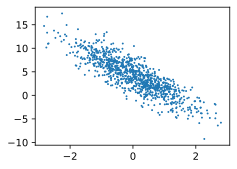

In [13]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

### 3.2.2 读取数据集

In [14]:
def data_iter(batch_size, features, labels):
  num_examples = len(features)
  indices = list(range(num_examples))
  random.shuffle(indices)
  for i in range(0, num_examples, batch_size):
    batch_indices = torch.tensor(
      indices[i: min(i+batch_size, num_examples)])
    yield features[batch_indices], labels[batch_indices]

In [15]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
  print(X, '\n', y)
  break

tensor([[ 0.2059, -1.4938],
        [ 0.8426,  0.1864],
        [-2.1003, -0.8359],
        [ 0.7761, -1.2928],
        [ 1.1423,  0.8853],
        [ 1.0496,  1.1850],
        [-0.3638,  0.3902],
        [ 0.1020,  0.8824],
        [-0.3331,  0.8780],
        [ 0.5143,  1.1519]]) 
 tensor([[ 9.7030],
        [ 5.2515],
        [ 2.8478],
        [10.1368],
        [ 3.4686],
        [ 2.2555],
        [ 2.1473],
        [ 1.4134],
        [ 0.5549],
        [ 1.3018]])


### 3.2.3 初始化模型参数

In [60]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 3.2.4 定义模型

In [29]:
def linreg(X, w, b): #@save
  return torch.matmul(X, w) + b

### 3.2.5 定义损失函数

In [30]:
def squared_loss(y_hat, y): #@save
  return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 3.2.6 定义优化算法


In [31]:
def sgd(params, lr, batch_size): #@save
  with torch.no_grad():
    for param in params:
      param -= lr * param.grad / batch_size
      param.grad.zero_()

### 3.2.7 训练

In [79]:
lr = 0.01
num_epochs = 10
batch_size = 20
net = linreg
loss = squared_loss

In [82]:
for epoch in range(num_epochs):
  for X, y in data_iter(batch_size, features, labels):
    l = loss(net(X, w, b), y)
    l.sum().backward()
    sgd([w,b], lr, batch_size)
  
  with torch.no_grad():
    train_l = loss(net(features, w, b), labels)
    print(f'epoch{epoch + 1}, loss {float(train_l.mean()):f}')

epoch1, loss 0.000051
epoch2, loss 0.000051
epoch3, loss 0.000051
epoch4, loss 0.000051
epoch5, loss 0.000051
epoch6, loss 0.000051
epoch7, loss 0.000051
epoch8, loss 0.000051
epoch9, loss 0.000051
epoch10, loss 0.000051


### 练习

1. 权重为0的时候的情况

In [59]:
w = torch.zeros((2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

for epoch in range(num_epochs):
  for X, y in data_iter(batch_size, features, labels):
    l = loss(net(X, w, b), y)
    l.sum().backward()
    sgd([w,b], lr, batch_size)
  
  with torch.no_grad():
    train_l = loss(net(features, w, b), labels)
    print(f'epoch{epoch + 1}, loss {float(train_l.mean()):f}')

epoch1, loss 2.335020
epoch2, loss 0.350923
epoch3, loss 0.053342


## 3.3 线性回归的简洁实现

### 3.3.1 生成数据集

In [83]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [85]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

### 3.3.2 读取数据集

In [86]:
def load_array(data_arrays, batch_size, is_train=True): #@save
  dataset = data.TensorDataset(*data_arrays)
  return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [87]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [89]:
next(iter(data_iter))

[tensor([[-4.8090e-01,  1.1690e+00],
         [ 7.8395e-01, -1.9611e+00],
         [-7.8975e-02, -1.6533e+00],
         [ 4.0661e-01,  5.8767e-02],
         [ 1.5722e-03,  9.9203e-01],
         [ 3.4719e-01, -1.9574e-01],
         [ 1.0733e+00, -1.1981e+00],
         [ 6.7026e-01,  6.1644e-01],
         [-5.9903e-01,  1.0451e+00],
         [-1.2662e+00, -1.3817e+00]]),
 tensor([[-0.7451],
         [12.4206],
         [ 9.6611],
         [ 4.8103],
         [ 0.8414],
         [ 5.5513],
         [10.4250],
         [ 3.4600],
         [-0.5490],
         [ 6.3669]])]

### 3.3.3 定义模型

In [90]:
from torch import nn

In [91]:
net = nn.Sequential(nn.Linear(2, 1))

### 3.3.4 初始化模型参数

In [93]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [95]:
net[0].weight.data, net[0].bias.data, 

(tensor([[ 0.0090, -0.0056]]), tensor([0.]))

### 3.3.5 定义损失函数

In [97]:
loss = nn.MSELoss()

### 3.3.6 定义优化算法

In [99]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 3.3.7 训练

In [100]:
num_epochs = 3
for expoch in range(num_epochs):
  for X, y in data_iter:
    l = loss(net(X), y)
    trainer.zero_grad()
    l.backward()
    trainer.step()
  l = loss(net(features), labels)
  print(f'epoch{epoch + 1}, loss{l:f}')

epoch10, loss0.000353
epoch10, loss0.000099
epoch10, loss0.000098


In [101]:
w = net[0].weight.data
print('w的估计误差: ', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差: ', true_b - b)

w的估计误差:  tensor([-0.0003,  0.0002])
b的估计误差:  tensor([0.0003])


### 练习

1. 总损失替换为平均损失，需要把新的学习率换为原来学习率 * batch_size

3. 梯度如何访问

In [103]:
net[0].weight.grad, net[0].bias.grad

(tensor([[-0.0074,  0.0015]]), tensor([-0.0065]))

## 3.5 图像分类数据集

In [104]:
%matplotlib inline
import torch 
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

### 3.5.1 读取数据集

In [105]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
  root='./data', train=True, transform=trans, download=True)

mnist_test = torchvision.datasets.FashionMNIST(
  root='./data', train=False, transform=trans, download=True)

100.0%


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [106]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [107]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [115]:
def get_fasion_mnist_labels(labels): #@save
  text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 
                 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
  return [text_labels[int(i)] for i in labels]

In [113]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): #@save
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    if torch.is_tensor(img):
      ax.imshow(img.numpy())
    else :
      ax.imshow(img)

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    if titles:
      ax.set_title(titles[i])
  return axes

array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirt'}>], dtype=object)

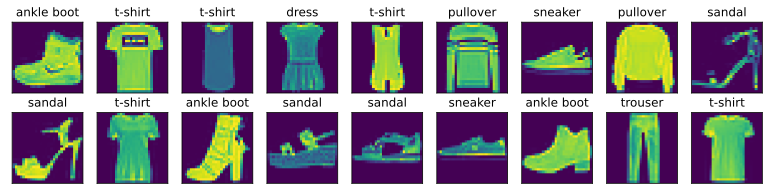

In [117]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fasion_mnist_labels(y))

### 3.5.2 读取小批量

In [118]:
batch_size = 256
def get_dataloader_warkers(): #@save
  return 4

trainer_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_warkers())

In [119]:
timer = d2l.Timer()
for X, y in trainer_iter:
  continue
f'{timer.stop():2f} sec'

'4.208124 sec'

### 3.5.3 整合所有组件

In [120]:
def load_data_fashion_mnist(batch_size, resize=None): #@save
  trans = [transforms.ToTensor()]
  if resize:
    trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
  
  mnist_train = torchvision.datasets.FashionMNIST(
    root='./data', train=True, transform=trans, download=True)

  mnist_test = torchvision.datasets.FashionMNIST(
    root='./data', train=False, transform=trans, download=True)
  
  return (
    data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_warkers()),
    data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=get_dataloader_warkers())
  )

In [121]:
trainer_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in trainer_iter:
  print(X.shape, X.dtype, y.shape, y.dtype)
  break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


### 练习

1. 减少batchsize是否影响读取性能

In [122]:
trainer_iter = data.DataLoader(mnist_train, 1, shuffle=True, num_workers=get_dataloader_warkers())

timer = d2l.Timer()
for X, y in trainer_iter:
  continue
f'{timer.stop():2f} sec'

'18.755013 sec'

如上所示，影响很大

2. 

3.其他数据集的示例

In [124]:
help(torchvision.datasets.CIFAR10)

Help on class CIFAR10 in module torchvision.datasets.cifar:

class CIFAR10(torchvision.datasets.vision.VisionDataset)
 |  CIFAR10(root: str, train: bool = True, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False) -> None
 |  
 |  `CIFAR10 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
 |  
 |  Args:
 |      root (string): Root directory of dataset where directory
 |          ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
 |      train (bool, optional): If True, creates dataset from training set, otherwise
 |          creates from test set.
 |      transform (callable, optional): A function/transform that takes in an PIL image
 |          and returns a transformed version. E.g, ``transforms.RandomCrop``
 |      target_transform (callable, optional): A function/transform that takes in the
 |          target and transforms it.
 |      download (bool, optional): If true, downloads the dataset f

## 3.6 softmax回归从0开始实现

In [1]:
import torch
from IPython import display
from d2l import torch as d2l

In [2]:
batch_size = 256
trainer_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### 3.6.1 初始化模型参数

In [3]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

### 3.6.2 定义softmax操作

In [4]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [5]:
def softmax(X):
  X_exp = torch.exp(X)
  partition = X_exp.sum(1, keepdim=True)
  return X_exp / partition

In [6]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(dim=1)

(tensor([[0.1461, 0.3236, 0.1078, 0.2930, 0.1295],
         [0.0399, 0.1887, 0.4912, 0.2015, 0.0788]]),
 tensor([1., 1.]))

### 3.6.3 定义模型

In [7]:
def net(X):
  return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

### 3.6.4 定义损失函数

In [8]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [9]:
def cross_entropy(y_hat, y):
  return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

### 3.6.5 分类精度

In [10]:
def accuracy(y_hat, y): #@save
  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    y_hat = y_hat.argmax(axis=1)
  cmp = y_hat.type(y.dtype) == y
  return float(cmp.type(y.dtype).sum())

In [11]:
accuracy(y_hat, y) / len(y)

0.5

In [12]:
class Accumulator: #@save
  def __init__(self, n):
    self.data = [0.0] * n
  
  def add(self, *args):
    self.data = [a + float(b) for a, b in zip(self.data, args)]
  
  def reset(self):
    self.data = [0.0] * len(self.data)
  
  def __getitem__(self, idx):
    return self.data[idx]

In [13]:
def evaluate_accuracy(net, data_iter):
  if isinstance(net, torch.nn.Module):
    net.eval()
  
  metric = Accumulator(2)
  with torch.no_grad():
    for X, y in data_iter:
      metric.add(accuracy(net(X), y), y.numel())
  
  return metric[0] / metric[1]

In [14]:
evaluate_accuracy(net, test_iter)

0.0434

### 3.6.6 训练

In [4]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [17]:
class Animator: #@save
  def __init__(self, xlabel=None, ylabel=None, legend=None,
               xlim=None, ylim=None, xscale='linear', yscale='linear',
               fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
               figsize=(3.5, 2.5)):
    if legend is None:
      legend = []
    
    d2l.use_svg_display()

    self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)

    if nrows * ncols == 1:
      self.axes = [self.axes, ]

    self.config_axes = lambda: d2l.set_axes(
      self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    
    self.X, self.Y, self.fmts = None, None, fmts

  def add(self, x, y):
    if not hasattr(y, "__len__"):
      y = [y]
    n = len(y)
    
    if not hasattr(x, "__len__"):
      x = [x] * n
    
    if not self.X:
      self.X = [[] for _ in range(n)]
      
    if not self.Y:
      self.Y = [[] for _ in range(n)]

    for i, (a, b) in enumerate(zip(x, y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    
    self.axes[0].cla()

    for x, y, fmt in zip(self.X, self.Y, self.fmts):
      self.axes[0].plot(x, y, fmt)
    
    self.config_axes()
    
    display.display(self.fig)
    display.clear_output(wait=True)

In [1]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [19]:
lr = 0.1

def updater(batch_size):
  return d2l.sgd([W, b], lr, batch_size)

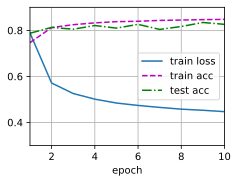

In [20]:
num_epochs = 10
train_ch3(net, trainer_iter, test_iter, cross_entropy, num_epochs, updater)

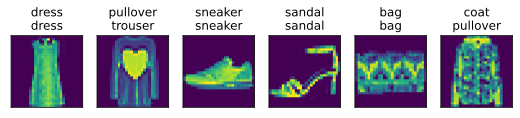

In [24]:
from symbol import break_stmt


def predict_ch3(net, test_iter, n=6): #@save
  for X, y in test_iter:
    break_stmt
  
  trues = d2l.get_fashion_mnist_labels(y)
  preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))

  titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
  d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

### 练习

1. 可能会溢出
2. log里面可能为0
3. 加上一个微小的偏置值
4. 应该对概率的阈值也有要求
5. 运行效率低

## 3.7 softmax回归的简洁实现

In [25]:
import torch
from torch import nn
from d2l import torch as d2l

In [26]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### 3.7.1 初始化模型参数

In [27]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

### 3.7.2 重新审视Softmax的实现

In [28]:
loss = nn.CrossEntropyLoss(reduction='none')

### 3.7.3 优化算法

In [29]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

### 3.7.4 训练

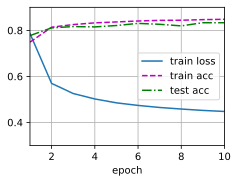

In [30]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)